In [42]:
import pandas as pd
import numpy as np
import pickle

#### 第一部分：获取EPS计算相关的财务数据

得到一个eps_rawdata.parquet的文件，包含netprofit的单季度数据，以及每个季度的平均shares outstanding，二者是计算EPS和市盈率的指标

In [43]:
IS_path = 'Z:/fundamental/IS_pit.pkl'

with open(IS_path, 'rb') as file:
    IS_table = pickle.load(file)
IS_table = pd.DataFrame(IS_table)

IS_table = IS_table.reset_index()
IS_table = IS_table.drop_duplicates(['order_book_id','quarter'],keep = 'first') 

In [44]:
# 计算单季度数据（把财报从‘累计数据’转换成‘单季度数据’）
def compute_adjusted_indicator(group,factors):
    # 创建一个新列用于存储调整后的收入
    for factor in factors:
        group[f'adj_{factor}'] = group[factor].diff()
        # 对于每年的第一个季度，其调整后的收入应当等于调整前的收入
        for i in range(1, 5):
            if i in group['quarter_num'].values:
                if i == 1:
                    first_row_index = group[group['quarter_num'] == i].index[0]
                    group.at[first_row_index, f'adj_{factor}'] = group.at[first_row_index, factor]
                else:
                    if i - 1 not in group['quarter_num'].values:
                        current_row_index = group[group['quarter_num'] == i].index[0]
                        group.at[current_row_index, f'adj_{factor}'] = pd.NA
    return group


In [45]:
# 将数据处理成单季度
IS_table['year'] = IS_table['quarter'].str[:4].astype(int)
IS_table['quarter_num'] = IS_table['quarter'].str[-1].astype(int)

IS_table.sort_values(by=['order_book_id', 'year', 'quarter_num'], inplace=True)
IS_table = IS_table.groupby(['order_book_id', 'year']).apply(compute_adjusted_indicator, factors= ['net_profit'])
IS_table = IS_table.reset_index(drop=True)


In [46]:
IS_table['order_book_id'] = IS_table['order_book_id'].str.slice(0,6)
IS_table = IS_table[['order_book_id','quarter','info_date','adj_net_profit']]
IS_table

,order_book_id,quarter,info_date,adj_net_profit
0,000001,2013q1,2013-04-24,3.589000e+09
1,000001,2013q2,2013-08-23,3.942000e+09
2,000001,2013q3,2013-10-23,4.165000e+09
3,000001,2013q4,2014-03-07,3.535000e+09
4,000001,2014q1,2014-04-24,5.054000e+09
...,...,...,...,...
202671,689009,2023q3,2023-10-31,1.562910e+08
202672,689009,2023q4,2024-04-02,2.178433e+08
202673,689009,2024q1,2024-04-25,1.355091e+08
202674,689009,2024q2,2024-08-07,4.603298e+08


In [47]:
df_market = pd.read_parquet('rawdata/processed_market_data.parquet')

In [48]:
# 获得季度平均的shares outstanding
df_market = df_market[['date','order_book_id','total_a']]
df_market['quarter'] = df_market['date'].dt.to_period('Q')

df_market = df_market.groupby(['order_book_id','quarter'])['total_a'].mean().reset_index()

df_market['quarter'] = df_market['quarter'].astype(str)
df_market['quarter'] = df_market['quarter'].str.lower()
df_market

,order_book_id,quarter,total_a
0,000001,2014q1,9.520746e+09
1,000001,2014q2,9.926548e+09
2,000001,2014q3,1.142489e+10
3,000001,2014q4,1.142489e+10
4,000001,2015q1,1.142489e+10
...,...,...,...
161236,689009,2023q4,7.202574e+07
161237,689009,2024q1,7.203469e+07
161238,689009,2024q2,7.149877e+07
161239,689009,2024q3,7.165895e+07


In [49]:
df1 = pd.merge(IS_table,df_market,on=['order_book_id','quarter'])
df1

,order_book_id,quarter,info_date,adj_net_profit,total_a
0,000001,2014q1,2014-04-24,5.054000e+09,9.520746e+09
1,000001,2014q2,2014-08-14,5.018000e+09,9.926548e+09
2,000001,2014q3,2014-10-24,5.622000e+09,1.142489e+10
3,000001,2014q4,2015-03-13,4.108000e+09,1.142489e+10
4,000001,2015q1,2015-04-24,5.629000e+09,1.142489e+10
...,...,...,...,...,...
156190,689009,2023q3,2023-10-31,1.562910e+08,7.165016e+07
156191,689009,2023q4,2024-04-02,2.178433e+08,7.202574e+07
156192,689009,2024q1,2024-04-25,1.355091e+08,7.203469e+07
156193,689009,2024q2,2024-08-07,4.603298e+08,7.149877e+07


In [50]:
df1.to_parquet('eps_rawdata.parquet')

### 第二部分：计算因子

计算以下因子：EPS，EPS_zscore，DST，DST_zscore，PRM，PRM_zscore,Sector_neu,Sector_neu_zscore

In [51]:
df_industry = pd.read_parquet('rawdata/industry.parquet')

In [52]:
df_industry

,order_book_id,first_industry_code,date
0,000001,40,2016-01-04
1,000002,42,2016-01-04
2,000004,35,2016-01-04
3,000005,42,2016-01-04
4,000006,42,2016-01-04
...,...,...,...
8695268,688799,35,2024-11-19
8695269,688800,60,2024-11-19
8695270,688819,27,2024-11-19
8695271,688981,60,2024-11-19


In [53]:
df_factor = pd.read_parquet('eps_rawdata.parquet')

In [54]:
df_factor['EPS'] = df_factor['adj_net_profit']/df_factor['total_a']
df_factor = df_factor[['order_book_id','quarter','info_date','EPS']]
df_factor = df_factor.dropna()
df_factor = df_factor.sort_values(['info_date','order_book_id'])
df_industry = df_industry.sort_values(['date','order_book_id'])
df_factor = pd.merge_asof(df_industry,df_factor, left_on=['date'],right_on=['info_date'],by=['order_book_id'],direction='backward')

In [55]:
# 每日每股的行业分组和每股EPS
df_factor

,order_book_id,first_industry_code,date,quarter,info_date,EPS
0,000001,40,2016-01-04,2015q3,2015-10-23,0.430159
1,000002,42,2016-01-04,2015q3,2015-10-28,0.282450
2,000004,35,2016-01-04,2015q3,2015-10-31,0.036099
3,000005,42,2016-01-04,2015q3,2015-10-30,-0.007270
4,000006,42,2016-01-04,2015q3,2015-10-28,0.014235
...,...,...,...,...,...,...
8695268,688799,35,2024-11-19,2024q3,2024-10-29,0.425075
8695269,688800,60,2024-11-19,2024q3,2024-10-25,0.256306
8695270,688819,27,2024-11-19,2024q3,2024-10-30,0.304240
8695271,688981,60,2024-11-19,2024q2,2024-08-30,0.603862


In [56]:
# 每日每个行业的EPS中位数，std和平均值
result = df_factor.groupby(['first_industry_code', 'date']).agg( EPS_related_median=('EPS', 'median'),
                                               EPS_related_std=('EPS', 'std'),
                                               EPS_related_mean=('EPS', 'mean')) 

result = result.reset_index()

In [57]:
result

,first_industry_code,date,EPS_related_median,EPS_related_std,EPS_related_mean
0,10,2016-01-04,0.020667,0.124077,0.002111
1,10,2016-01-05,0.020667,0.124077,0.002111
2,10,2016-01-06,0.020667,0.124077,0.002111
3,10,2016-01-07,0.020667,0.124077,0.002111
4,10,2016-01-08,0.020667,0.124077,0.002111
...,...,...,...,...,...
63752,70,2024-11-13,0.002238,0.065996,0.012809
63753,70,2024-11-14,0.002238,0.065996,0.012809
63754,70,2024-11-15,0.002238,0.065996,0.012809
63755,70,2024-11-18,0.002238,0.065996,0.012809


In [58]:
# 将行业中位数结果合并到factor表格中
df = pd.merge(df_factor,result,on=['first_industry_code','date'],how='outer')
df

,order_book_id,first_industry_code,date,quarter,info_date,EPS,EPS_related_median,EPS_related_std,EPS_related_mean
0,000001,40,2016-01-04,2015q3,2015-10-23,0.430159,0.414577,1.465842,0.782148
1,002142,40,2016-01-04,2015q3,2015-10-30,0.467757,0.414577,1.465842,0.782148
2,600000,40,2016-01-04,2015q3,2015-10-30,0.715631,0.414577,1.465842,0.782148
3,600015,40,2016-01-04,2015q3,2015-10-31,0.442614,0.414577,1.465842,0.782148
4,600016,40,2016-01-04,2015q3,2015-10-31,0.398995,0.414577,1.465842,0.782148
...,...,...,...,...,...,...,...,...,...
8695268,603958,34,2024-11-19,2024q3,2024-10-30,-0.133436,0.062887,0.150832,0.075219
8695269,605003,34,2024-11-19,2024q3,2024-10-24,0.188610,0.062887,0.150832,0.075219
8695270,605055,34,2024-11-19,2024q3,2024-10-31,-0.001105,0.062887,0.150832,0.075219
8695271,605138,34,2024-11-19,2024q3,2024-10-29,0.017059,0.062887,0.150832,0.075219


In [59]:
from backtesting import process_factors,neutralize_factors,calculate_and_plot_ic,calculate_benchmark_return,custom_quantile_grouping,get_pnl,plot_cumulative_returns,calculate_annual_metrics

In [60]:
# 假设一年是250个交易日
df['DST'] = df['EPS'] - df['EPS_related_median']
df['PRM'] = df['DST'] / df['EPS_related_std']


df['DST_mean'] = df.groupby('order_book_id')['DST'].rolling(250).mean().reset_index(0,drop=True)
df['DST_std'] = df.groupby('order_book_id')['DST'].rolling(250).std().reset_index(0,drop=True)
df['DST_zscore'] = (df['DST']-df['DST_mean'])/df['DST_std']

df['PRM_mean'] = df.groupby('order_book_id')['PRM'].rolling(250).mean().reset_index(0,drop=True)
df['PRM_std'] = df.groupby('order_book_id')['PRM'].rolling(250).std().reset_index(0,drop=True)
df['PRM_zscore'] = (df['PRM']-df['PRM_mean'])/df['PRM_std']

df['EPS_mean'] = df.groupby('order_book_id')['EPS'].rolling(250).mean().reset_index(0,drop=True)
df['EPS_std'] = df.groupby('order_book_id')['EPS'].rolling(250).std().reset_index(0,drop=True)
df['EPS_zscore'] = (df['EPS']-df['EPS_mean'])/df['EPS_std']



# 另一种版本的DST，区别是减掉的是mean而不是median
df['DST2'] = df['EPS'] - df['EPS_related_mean']
df['PRM2'] = df['DST'] / df['EPS_related_std']


df['DST2_mean'] = df.groupby('order_book_id')['DST2'].rolling(250).mean().reset_index(0,drop=True)
df['DST2_std'] = df.groupby('order_book_id')['DST2'].rolling(250).std().reset_index(0,drop=True)
df['DST2_zscore'] = (df['DST2']-df['DST2_mean'])/df['DST2_std']

df['PRM2_mean'] = df.groupby('order_book_id')['PRM2'].rolling(250).mean().reset_index(0,drop=True)
df['PRM2_std'] = df.groupby('order_book_id')['PRM2'].rolling(250).std().reset_index(0,drop=True)
df['PRM2_zscore'] = (df['PRM2']-df['PRM2_mean'])/df['PRM2_std']

In [61]:
df_market = pd.read_parquet('rawdata/processed_market_data.parquet')

df_industry = pd.read_parquet('rawdata/industry.parquet')
df_industry['order_book_id'] = df_industry['order_book_id'].str[:6]

df_industry = pd.merge(df_market[['order_book_id','date']], df_industry, how = 'left')
df_industry['first_industry_code'] = df_industry['first_industry_code'].ffill()
df_industry.dropna(inplace=True)

df_industry = pd.get_dummies(df_industry, columns = ['first_industry_code'],prefix='industry')
df_industry = df_industry.astype({col: 'int' for col in df_industry.columns if col.startswith('industry_')})

In [62]:
df = pd.merge(df_market,df, on=['date','order_book_id'])

In [63]:
# 对EPS因子做行业中性化取残差，得到 sector_neu因子

df = process_factors(df,factors= ['EPS'],process_method='rank')
df = neutralize_factors(df, factors=  ['EPS'], market_factor=False,momentum_factor=False, industry_factor=True, df_industry = df_industry)
df = df.drop(['industry_10', 'industry_11', 'industry_12',
       'industry_20', 'industry_21', 'industry_22', 'industry_23',
       'industry_24', 'industry_25', 'industry_26', 'industry_27',
       'industry_28', 'industry_30', 'industry_31', 'industry_32',
       'industry_33', 'industry_34', 'industry_35', 'industry_36',
       'industry_37', 'industry_40', 'industry_41', 'industry_42',
       'industry_43', 'industry_50', 'industry_60', 'industry_61',
       'industry_62', 'industry_63', 'industry_70'],axis=1)


df = df.rename(columns={'neu_EPS_process':'sector_neu'})

yes,it is rank
Finish neutralize


In [64]:
# 计算sector_neu因子的时间序列zscore
df['sector_neu_mean']= df.groupby('order_book_id')['sector_neu'].rolling(250).mean().reset_index(0,drop=True)
df['sector_neu_std'] = df.groupby('order_book_id')['sector_neu'].rolling(250).std().reset_index(0,drop=True)
df['sector_neu_zscore'] = (df['sector_neu']-df['sector_neu_mean'])/df['sector_neu_std']

#### 第三部分 因子回测

In [65]:
df_eps = df.copy()

In [66]:
# 行业市值动量中性化
df_eps = process_factors(df_eps,factors= ['EPS','DST','PRM','EPS_zscore','DST_zscore','PRM_zscore','sector_neu','sector_neu_zscore','DST2','DST2_zscore'],process_method='rank')
df_eps = neutralize_factors(df_eps, factors=  ['EPS','DST','PRM','EPS_zscore','DST_zscore','PRM_zscore','sector_neu','sector_neu_zscore','DST2','DST2_zscore'], market_factor=True,
                                        momentum_factor=True, industry_factor=True, df_industry = df_industry)

yes,it is rank
yes,it is rank
yes,it is rank
yes,it is rank
yes,it is rank
yes,it is rank
yes,it is rank
yes,it is rank
yes,it is rank
yes,it is rank
Finish neutralize


In [67]:
df_eps

,date,order_book_id,adj_close,adj_factor,adj_high,adj_low,adj_open,circulation_a,circulation_market_value,close,...,neu_EPS_process,neu_DST_process,neu_PRM_process,neu_EPS_zscore_process,neu_DST_zscore_process,neu_PRM_zscore_process,neu_sector_neu_process,neu_sector_neu_zscore_process,neu_DST2_process,neu_DST2_zscore_process
0,2017-01-10,000001,7.505731,1.219069,7.513934,7.497528,7.505731,1.691799e+10,1.547996e+11,9.15,...,119.812500,204.687500,-19.656250,-76.500000,198.125000,158.375000,120.250000,76.062500,-290.750000,20.000000
1,2017-01-10,000005,7.010000,1.000000,7.080000,7.010000,7.070000,9.512225e+08,6.668069e+09,7.01,...,-495.125000,-314.437500,-377.375000,170.500000,218.750000,-135.875000,-529.562500,67.687500,-353.750000,180.000000
2,2017-01-10,000006,7.973132,1.224111,8.128347,7.899609,8.103839,1.345151e+09,1.312868e+10,9.76,...,-530.250000,-374.062500,-449.609375,-666.875000,-593.250000,-968.750000,-559.875000,-508.375000,-433.875000,-360.750000
3,2017-01-10,000009,8.636469,1.229669,8.734057,8.547014,8.555147,2.120066e+09,2.251510e+10,10.62,...,15.937500,35.812500,-36.640625,-422.750000,-353.125000,-360.250000,58.375000,-145.875000,-5.250000,-40.125000
4,2017-01-10,000010,7.710000,1.000000,7.810000,7.690000,7.740000,4.079299e+08,3.145140e+09,7.71,...,-1035.187500,-943.812500,-1048.703125,46.375000,-21.250000,-78.375000,-1120.375000,-189.500000,-899.375000,-89.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6724753,2024-11-18,688799,39.840000,1.000000,40.980000,39.600000,40.200000,9.380000e+07,3.736992e+09,39.84,...,2112.531457,2251.356881,1879.637880,-890.431122,-1209.461198,1507.943977,2181.374417,1387.447657,2183.966311,-968.074673
6724754,2024-11-18,688800,37.080000,1.000000,38.580000,36.710000,38.360000,1.584199e+08,5.874209e+09,37.08,...,1613.548405,1712.119199,1750.234691,1053.864935,830.893993,901.192444,1694.928027,787.852118,1677.561265,736.310237
6724755,2024-11-18,688819,29.870000,1.000000,30.600000,29.650000,30.070000,9.721000e+08,2.903663e+10,29.87,...,1176.829547,1225.269503,1267.200402,-2389.726518,-2424.498501,-2394.038854,1235.683623,-2388.002425,1147.418855,-2602.773822
6724756,2024-11-18,688981,92.300000,1.000000,97.500000,91.370000,95.700000,1.988359e+09,1.835255e+11,92.30,...,1303.328447,1343.751032,1433.258122,-282.340354,-365.069692,201.645618,1354.304177,-489.409925,1332.908687,-317.244314


In [68]:
df_eps = df_eps[df_eps['date']>='2017-01-01']
df_eps.groupby('date')['order_book_id'].count()

date
2017-01-10    1275
2017-01-11    1279
2017-01-12    1350
2017-01-13    1378
2017-01-16    1418
              ... 
2024-11-12    4856
2024-11-13    4855
2024-11-14    4856
2024-11-15    4855
2024-11-18    4857
Name: order_book_id, Length: 1907, dtype: int64

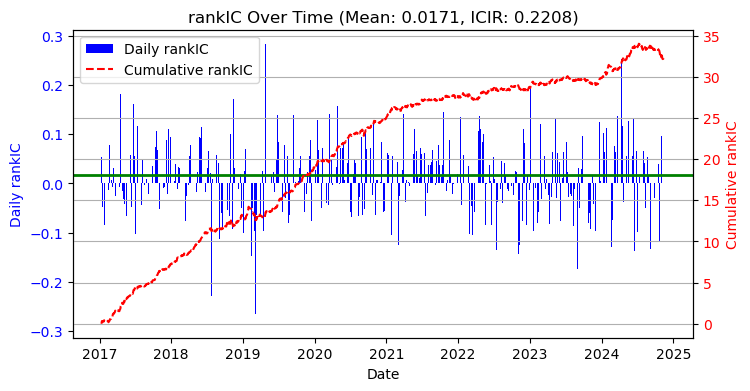

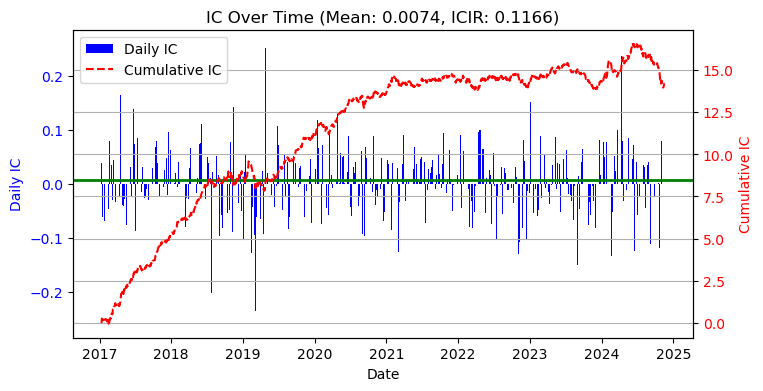

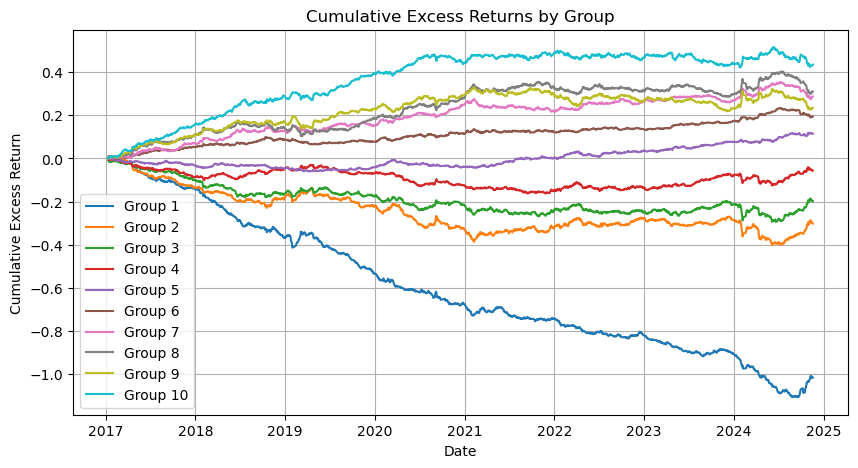

,net_excess_return,gross_excess_return,sharpe_net,sharpe_gross,turnover_rate
quantile,,,,,
0,-0.154684,-0.133362,-3.613061,-3.122768,0.071071
1,-0.081485,-0.039610,-1.732926,-0.845768,0.139583
2,-0.072720,-0.026001,-1.668892,-0.599406,0.155728
3,-0.054879,-0.007475,-1.625258,-0.222210,0.158012
4,-0.032202,0.015039,-1.371579,0.644613,0.157470
5,-0.021636,0.025514,-0.925427,1.092779,0.157167
6,-0.008697,0.037656,-0.269588,1.167361,0.154509
7,-0.003782,0.040651,-0.090008,0.965920,0.148110
8,-0.007124,0.030759,-0.163952,0.707039,0.126278


In [40]:
calculate_and_plot_ic(df_eps, factor='neu_EPS_process', ret='ret_daily', ic_type='both')

# 算benchmark
df1 = calculate_benchmark_return(df_eps, 'neu_EPS_process', 'ret_overnight', 'ret_day', 'ret_daily')

df1['neu_EPS_process'] = df1['neu_EPS_process'].astype('float')

# 分组
df1['quantile'] = df1.groupby(['date'])['neu_EPS_process'].transform(lambda x: pd.qcut(x,10,labels=False,duplicates='drop'))

pnl_result = get_pnl(df1)

plot_cumulative_returns(pnl_result.pivot(index='date', columns='quantile', values='cum_gross_excess'))

calculate_annual_metrics(pnl_result)

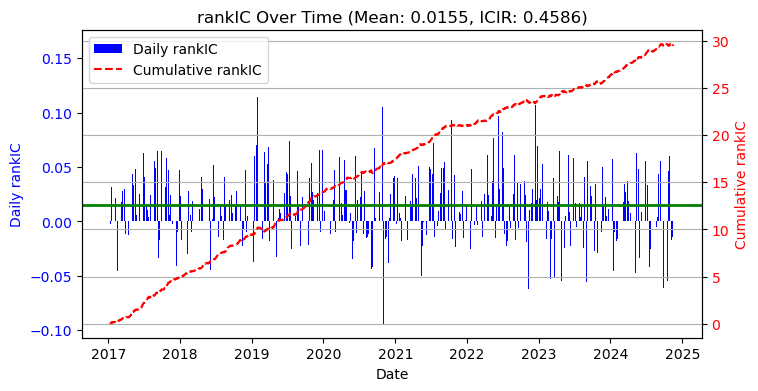

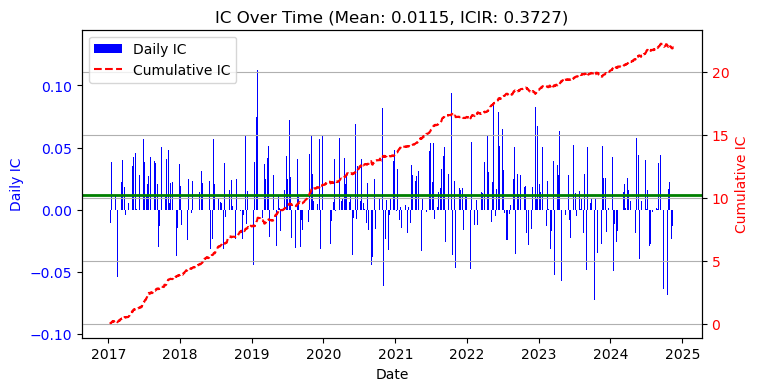

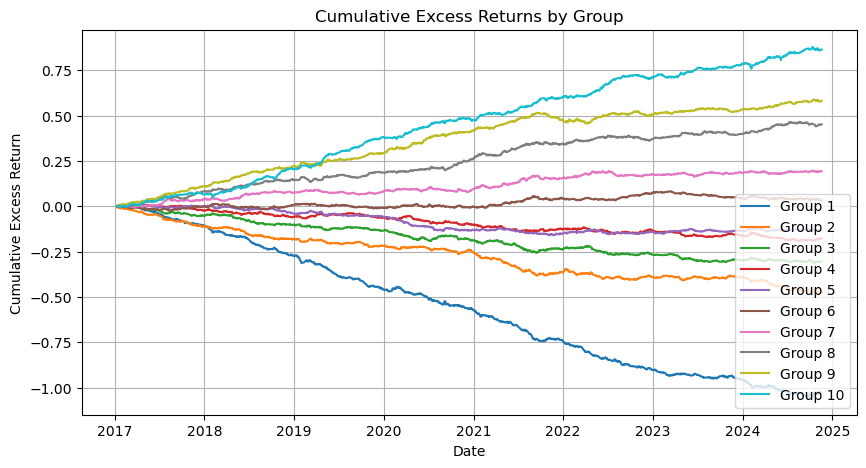

,net_excess_return,gross_excess_return,sharpe_net,sharpe_gross,turnover_rate
quantile,,,,,
0,-0.164731,-0.135023,-5.211694,-4.301155,0.099025
1,-0.115415,-0.062492,-4.396196,-2.415674,0.176411
2,-0.097183,-0.040060,-3.807524,-1.598573,0.190410
3,-0.080557,-0.023135,-3.448916,-1.011636,0.191407
4,-0.074664,-0.017285,-3.463242,-0.812144,0.191262
5,-0.054090,0.003955,-2.459020,0.180745,0.193483
6,-0.033412,0.025335,-1.372534,1.046202,0.195824
7,0.001022,0.059343,0.038348,2.219513,0.194402
8,0.023158,0.076245,0.843402,2.767435,0.176955


In [69]:
calculate_and_plot_ic(df_eps, factor='neu_EPS_zscore_process', ret='ret_daily', ic_type='both')

# 算benchmark
df1 = calculate_benchmark_return(df_eps, 'neu_EPS_zscore_process', 'ret_overnight', 'ret_day', 'ret_daily')

df1['neu_EPS_zscore_process'] = df1['neu_EPS_zscore_process'].astype('float')

# 分组
df1['quantile'] = df1.groupby(['date'])['neu_EPS_zscore_process'].transform(lambda x: pd.qcut(x,10,labels=False,duplicates='drop'))

pnl_result = get_pnl(df1)

plot_cumulative_returns(pnl_result.pivot(index='date', columns='quantile', values='cum_gross_excess'))

calculate_annual_metrics(pnl_result)

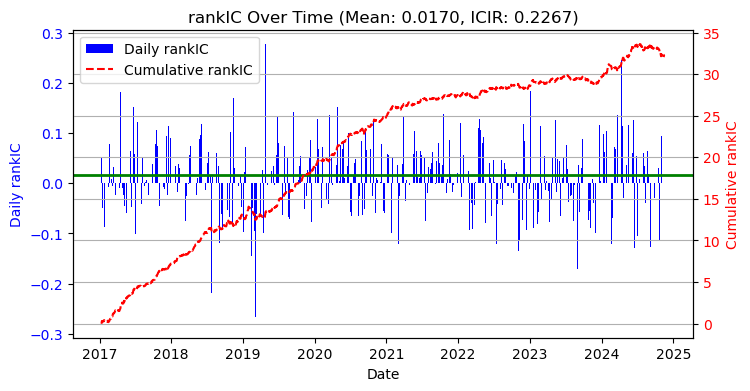

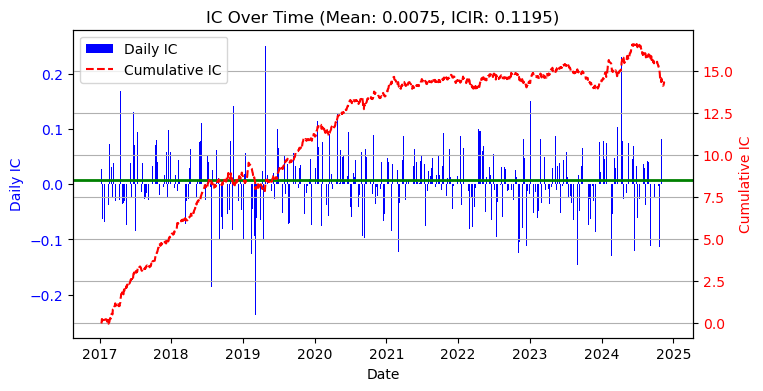

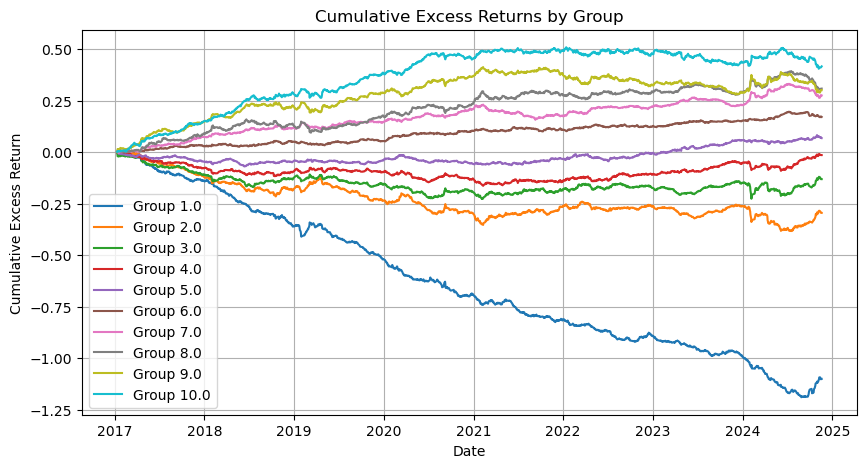

,net_excess_return,gross_excess_return,sharpe_net,sharpe_gross,turnover_rate
quantile,,,,,
0.0,-0.166744,-0.144268,-3.922061,-3.399786,0.074921
1.0,-0.082585,-0.038606,-1.903812,-0.893886,0.146598
2.0,-0.065561,-0.017131,-1.606956,-0.422392,0.161434
3.0,-0.050282,-0.001822,-1.506185,-0.054905,0.161535
4.0,-0.038635,0.009001,-1.427807,0.334562,0.158788
5.0,-0.024136,0.022465,-1.063516,0.991945,0.155335
6.0,-0.009655,0.036165,-0.334002,1.251745,0.152731
7.0,-0.004065,0.040507,-0.100548,1.000435,0.148571
8.0,0.001084,0.039556,0.023837,0.868629,0.128239


In [31]:
calculate_and_plot_ic(df_eps, factor='neu_DST_process', ret='ret_daily', ic_type='both')

# 算benchmark
df1 = calculate_benchmark_return(df_eps, 'neu_DST_process', 'ret_overnight', 'ret_day', 'ret_daily')

df1['neu_DST_process'] = df1['neu_DST_process'].astype('float')

# 分组
df1 = custom_quantile_grouping(df1, 'date', 'neu_DST_process')

pnl_result = get_pnl(df1)

plot_cumulative_returns(pnl_result.pivot(index='date', columns='quantile', values='cum_gross_excess'))

calculate_annual_metrics(pnl_result)

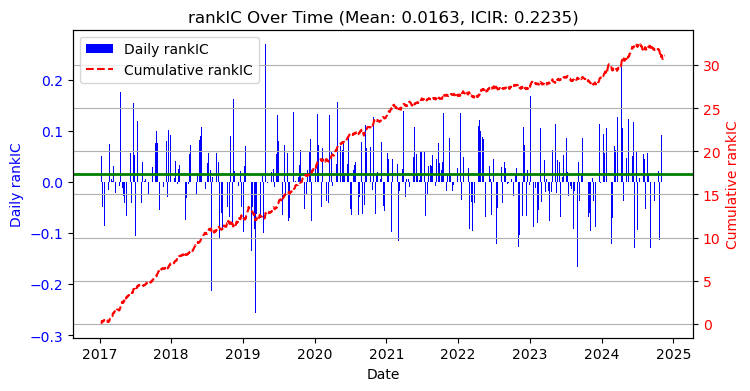

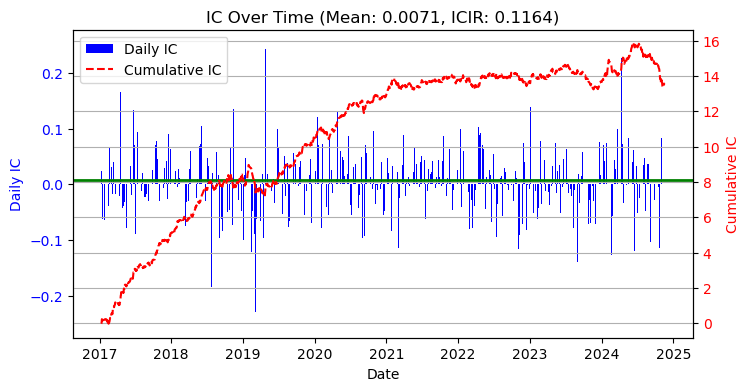

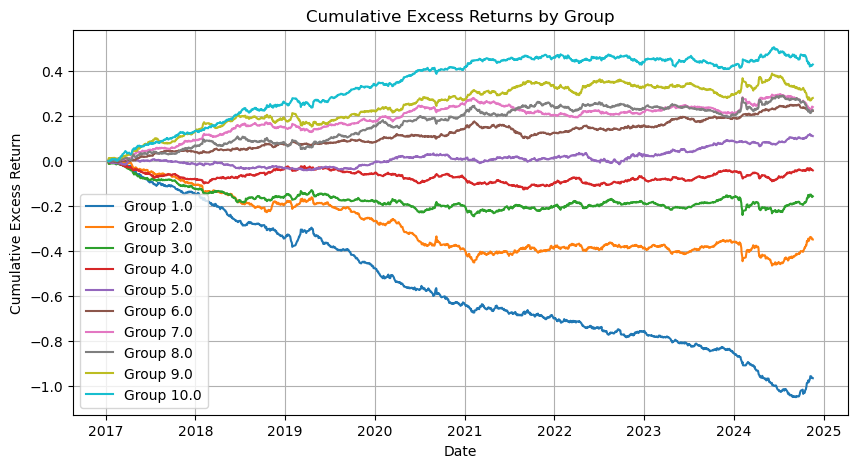

,net_excess_return,gross_excess_return,sharpe_net,sharpe_gross,turnover_rate
quantile,,,,,
0.0,-0.149114,-0.126571,-3.345466,-2.847007,0.075143
1.0,-0.090494,-0.045653,-1.909659,-0.968294,0.149468
2.0,-0.069973,-0.020473,-1.719054,-0.506403,0.165003
3.0,-0.054959,-0.005364,-1.804256,-0.177138,0.165318
4.0,-0.033892,0.014658,-1.184352,0.513782,0.161833
5.0,-0.017548,0.029337,-0.648014,1.083726,0.156284
6.0,-0.014309,0.031588,-0.448256,0.986644,0.152992
7.0,-0.015201,0.029681,-0.379309,0.740674,0.149608
8.0,-0.002970,0.036894,-0.070357,0.872705,0.132880


In [32]:
calculate_and_plot_ic(df_eps, factor='neu_PRM_process', ret='ret_daily', ic_type='both')

# 算benchmark
df1 = calculate_benchmark_return(df_eps, 'neu_PRM_process', 'ret_overnight', 'ret_day', 'ret_daily')

df1['neu_PRM_process'] = df1['neu_PRM_process'].astype('float')

# 分组
df1 = custom_quantile_grouping(df1, 'date', 'neu_PRM_process')

pnl_result = get_pnl(df1)

plot_cumulative_returns(pnl_result.pivot(index='date', columns='quantile', values='cum_gross_excess'))

calculate_annual_metrics(pnl_result)

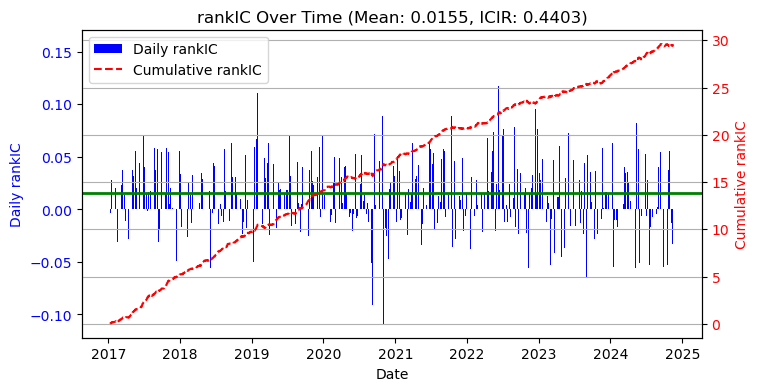

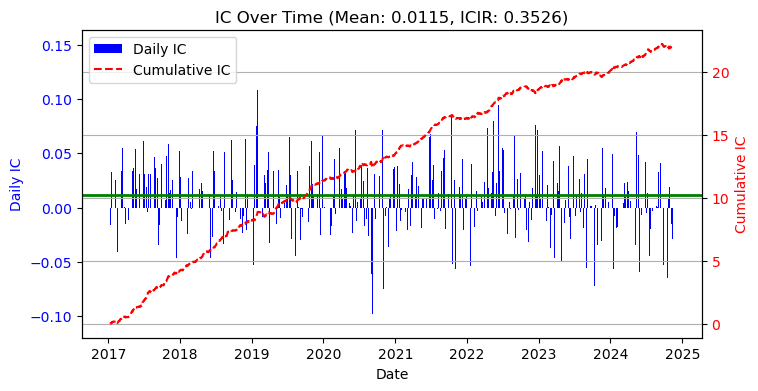

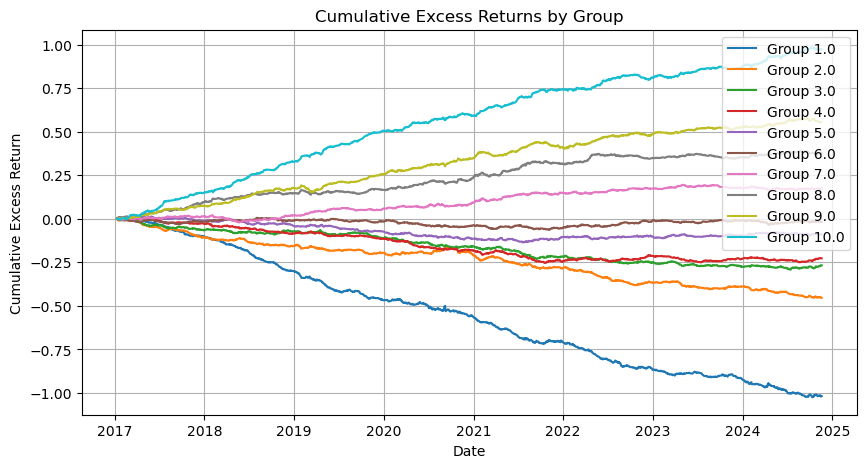

,net_excess_return,gross_excess_return,sharpe_net,sharpe_gross,turnover_rate
quantile,,,,,
0.0,-0.167137,-0.133548,-4.961337,-3.990311,0.111963
1.0,-0.120029,-0.059561,-4.629981,-2.334374,0.201561
2.0,-0.099233,-0.035073,-4.064185,-1.467967,0.213865
3.0,-0.093894,-0.029797,-4.204262,-1.361200,0.213656
4.0,-0.075384,-0.011845,-3.452321,-0.551973,0.211799
5.0,-0.065903,-0.002401,-3.080660,-0.113918,0.211671
6.0,-0.041156,0.022953,-1.853477,1.040642,0.213698
7.0,-0.014678,0.049532,-0.586811,1.972962,0.214035
8.0,0.013152,0.072879,0.483469,2.677157,0.199090


In [33]:
calculate_and_plot_ic(df_eps, factor='neu_DST_zscore_process', ret='ret_daily', ic_type='both')

# 算benchmark
df1 = calculate_benchmark_return(df_eps, 'neu_DST_zscore_process', 'ret_overnight', 'ret_day', 'ret_daily')

df1['neu_DST_zscore_process'] = df1['neu_DST_zscore_process'].astype('float')

# 分组
df1 = custom_quantile_grouping(df1, 'date', 'neu_DST_zscore_process')

pnl_result = get_pnl(df1)

plot_cumulative_returns(pnl_result.pivot(index='date', columns='quantile', values='cum_gross_excess'))

calculate_annual_metrics(pnl_result)

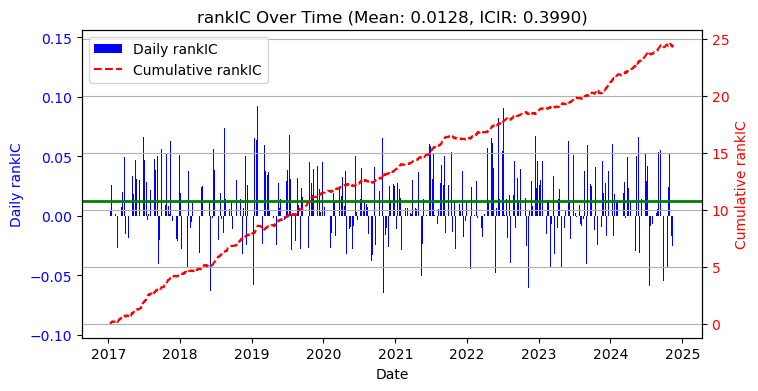

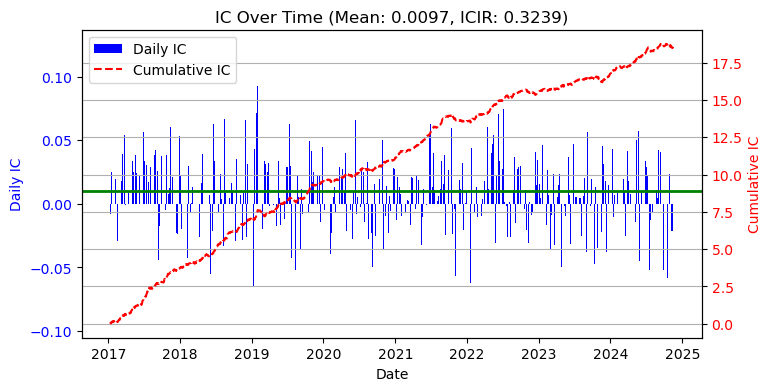

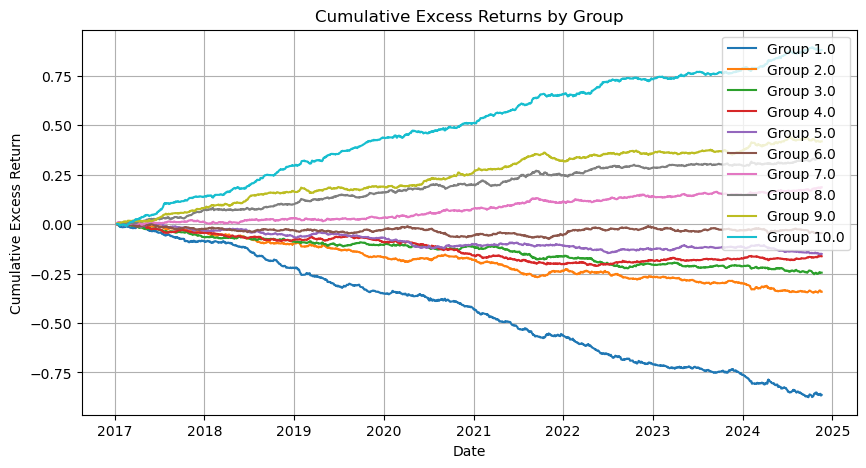

,net_excess_return,gross_excess_return,sharpe_net,sharpe_gross,turnover_rate
quantile,,,,,
0.0,-0.147317,-0.113220,-4.480004,-3.473241,0.113656
1.0,-0.105645,-0.044906,-4.134995,-1.780812,0.202461
2.0,-0.096898,-0.032231,-3.958177,-1.342385,0.215555
3.0,-0.085857,-0.021352,-3.922595,-1.002219,0.215016
4.0,-0.084460,-0.019820,-4.041064,-0.962177,0.215467
5.0,-0.071199,-0.005976,-3.243778,-0.277644,0.217408
6.0,-0.041268,0.024402,-1.825180,1.085869,0.218901
7.0,-0.021701,0.043756,-0.882723,1.791746,0.218190
8.0,-0.005923,0.054798,-0.231261,2.153919,0.202406


In [34]:
calculate_and_plot_ic(df_eps, factor='neu_PRM_zscore_process', ret='ret_daily', ic_type='both')

# 算benchmark
df1 = calculate_benchmark_return(df_eps, 'neu_PRM_zscore_process', 'ret_overnight', 'ret_day', 'ret_daily')

df1['neu_PRM_zscore_process'] = df1['neu_PRM_zscore_process'].astype('float')

# 分组
df1 = custom_quantile_grouping(df1, 'date', 'neu_PRM_zscore_process')

pnl_result = get_pnl(df1)

plot_cumulative_returns(pnl_result.pivot(index='date', columns='quantile', values='cum_gross_excess'))

calculate_annual_metrics(pnl_result)

In [35]:
df_eps.columns

Index(['date', 'order_book_id', 'adj_close', 'adj_factor', 'adj_high',
       'adj_low', 'adj_open', 'circulation_a', 'circulation_market_value',
       'close',
       ...
       'industry_70', 'neu_EPS_process', 'neu_DST_process', 'neu_PRM_process',
       'neu_DST_zscore_process', 'neu_PRM_zscore_process',
       'neu_sector_neu_process', 'neu_sector_neu_zscore_process',
       'neu_DST2_process', 'neu_DST2_zscore_process'],
      dtype='object', length=105)

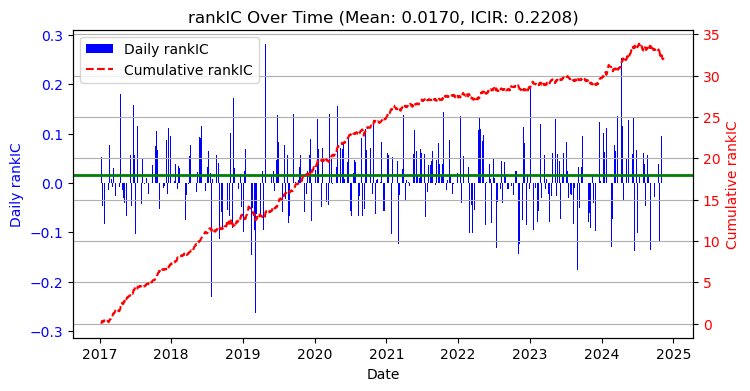

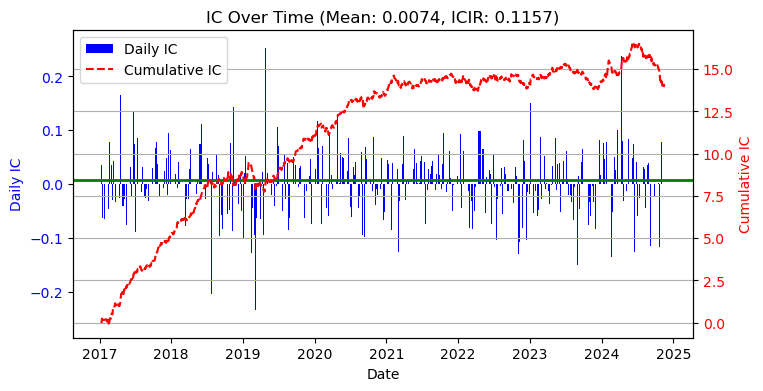

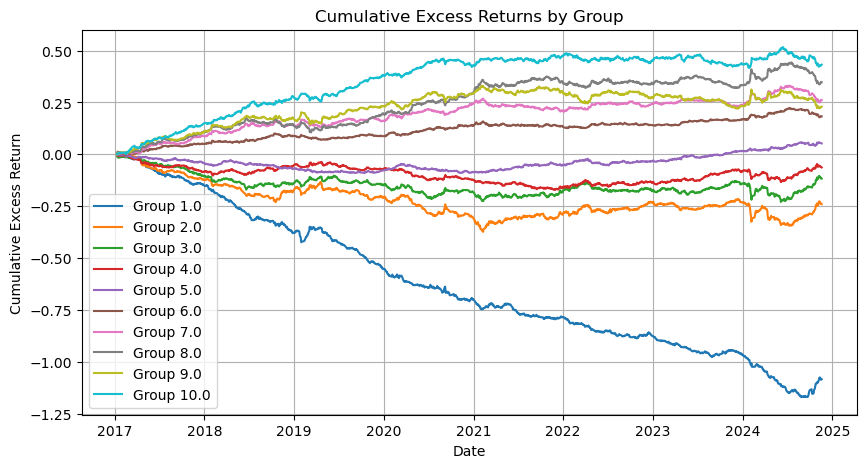

,net_excess_return,gross_excess_return,sharpe_net,sharpe_gross,turnover_rate
quantile,,,,,
0.0,-0.165789,-0.142130,-3.902383,-3.353568,0.078863
1.0,-0.076364,-0.031498,-1.548389,-0.640914,0.149552
2.0,-0.062765,-0.015357,-1.407449,-0.345861,0.158027
3.0,-0.055506,-0.008272,-1.656984,-0.247893,0.157445
4.0,-0.040189,0.006864,-1.721383,0.296194,0.156842
5.0,-0.023264,0.024030,-0.977904,1.010825,0.157648
6.0,-0.012870,0.034363,-0.383648,1.024275,0.157444
7.0,-0.000127,0.045606,-0.002969,1.065083,0.152442
8.0,-0.009383,0.030157,-0.213724,0.686018,0.131799


In [36]:
calculate_and_plot_ic(df_eps, factor='neu_sector_neu_process', ret='ret_daily', ic_type='both')

# 算benchmark
df1 = calculate_benchmark_return(df_eps, 'neu_sector_neu_process', 'ret_overnight', 'ret_day', 'ret_daily')

df1['neu_sector_neu_process'] = df1['neu_sector_neu_process'].astype('float')

# 分组
df1 = custom_quantile_grouping(df1, 'date', 'neu_sector_neu_process')

pnl_result = get_pnl(df1)

plot_cumulative_returns(pnl_result.pivot(index='date', columns='quantile', values='cum_gross_excess'))

calculate_annual_metrics(pnl_result)

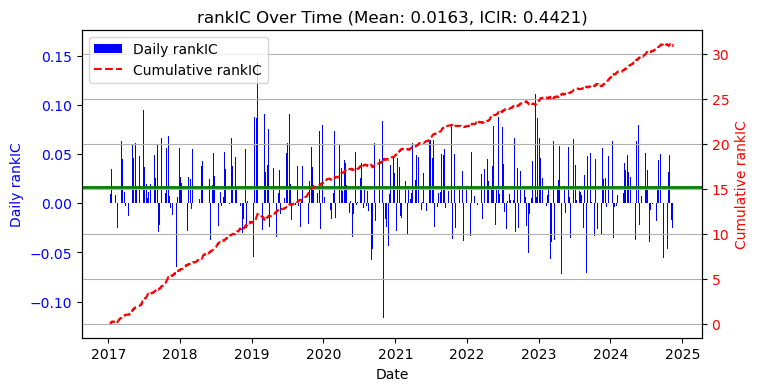

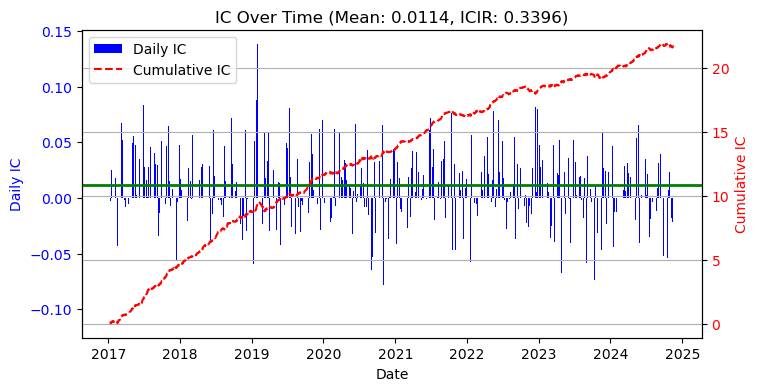

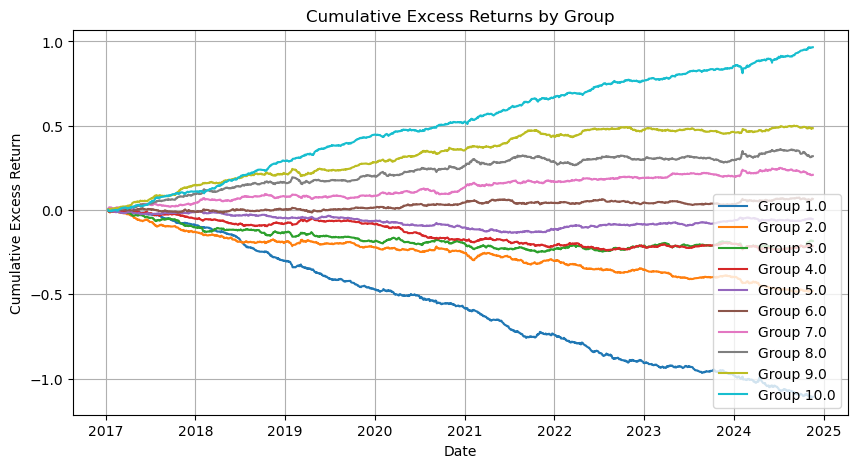

,net_excess_return,gross_excess_return,sharpe_net,sharpe_gross,turnover_rate
quantile,,,,,
0.0,-0.191973,-0.145364,-5.524410,-4.218078,0.155364
1.0,-0.150982,-0.062891,-5.186382,-2.184044,0.293637
2.0,-0.120006,-0.024130,-4.068597,-0.828264,0.319586
3.0,-0.126048,-0.028128,-4.766764,-1.077321,0.326400
4.0,-0.104814,-0.007136,-4.607459,-0.319235,0.325594
5.0,-0.089414,0.008657,-3.841746,0.375734,0.326905
6.0,-0.071953,0.027412,-2.695335,1.033150,0.331216
7.0,-0.057140,0.041912,-1.809458,1.329064,0.330175
8.0,-0.025324,0.063702,-0.878034,2.206881,0.296752


In [37]:
calculate_and_plot_ic(df_eps, factor='neu_sector_neu_zscore_process', ret='ret_daily', ic_type='both')

# 算benchmark
df1 = calculate_benchmark_return(df_eps, 'neu_sector_neu_zscore_process', 'ret_overnight', 'ret_day', 'ret_daily')

df1['neu_sector_neu_zscore_process'] = df1['neu_sector_neu_zscore_process'].astype('float')

# 分组
df1 = custom_quantile_grouping(df1, 'date', 'neu_sector_neu_zscore_process')

pnl_result = get_pnl(df1)

plot_cumulative_returns(pnl_result.pivot(index='date', columns='quantile', values='cum_gross_excess'))

calculate_annual_metrics(pnl_result)

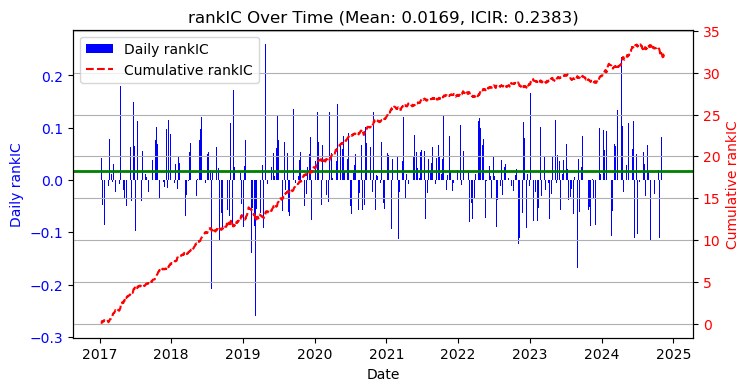

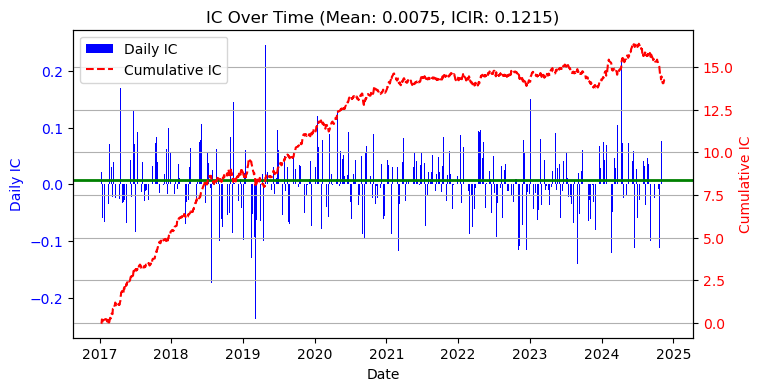

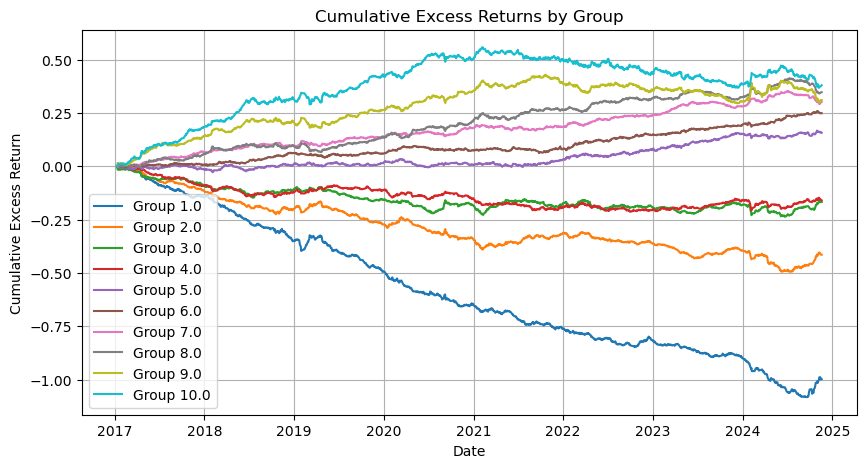

,net_excess_return,gross_excess_return,sharpe_net,sharpe_gross,turnover_rate
quantile,,,,,
0.0,-0.152211,-0.130926,-3.627015,-3.126693,0.070948
1.0,-0.099447,-0.054416,-2.743543,-1.511417,0.150104
2.0,-0.075517,-0.021939,-2.160716,-0.631239,0.178591
3.0,-0.076290,-0.021008,-2.343161,-0.650095,0.184273
4.0,-0.032750,0.020587,-1.133197,0.716993,0.177790
5.0,-0.016614,0.032618,-0.653027,1.287580,0.164107
6.0,-0.005971,0.039520,-0.234350,1.550428,0.151637
7.0,0.004005,0.045555,0.121303,1.377114,0.138499
8.0,0.005256,0.040741,0.119559,0.925712,0.118285


In [38]:
calculate_and_plot_ic(df_eps, factor='neu_DST2_process', ret='ret_daily', ic_type='both')

# 算benchmark
df1 = calculate_benchmark_return(df_eps, 'neu_DST2_process', 'ret_overnight', 'ret_day', 'ret_daily')

df1['neu_DST2_process'] = df1['neu_DST2_process'].astype('float')

# 分组
df1 = custom_quantile_grouping(df1, 'date', 'neu_DST2_process')

pnl_result = get_pnl(df1)

plot_cumulative_returns(pnl_result.pivot(index='date', columns='quantile', values='cum_gross_excess'))

calculate_annual_metrics(pnl_result)

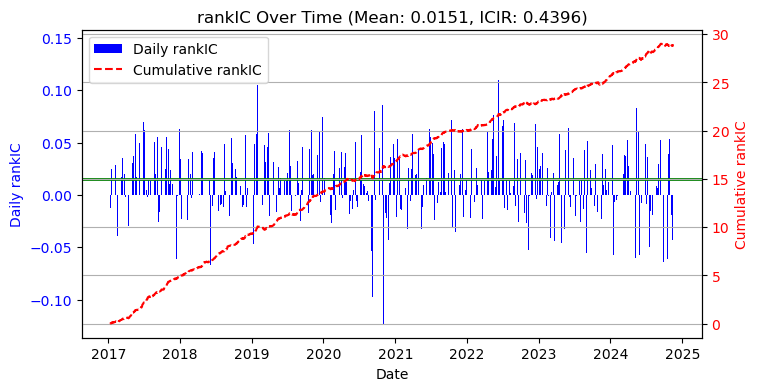

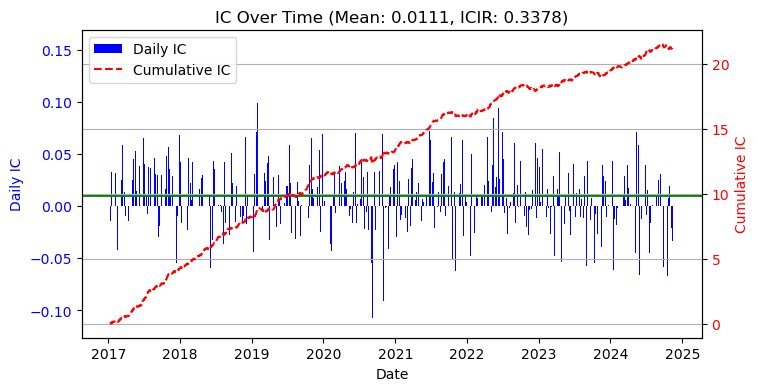

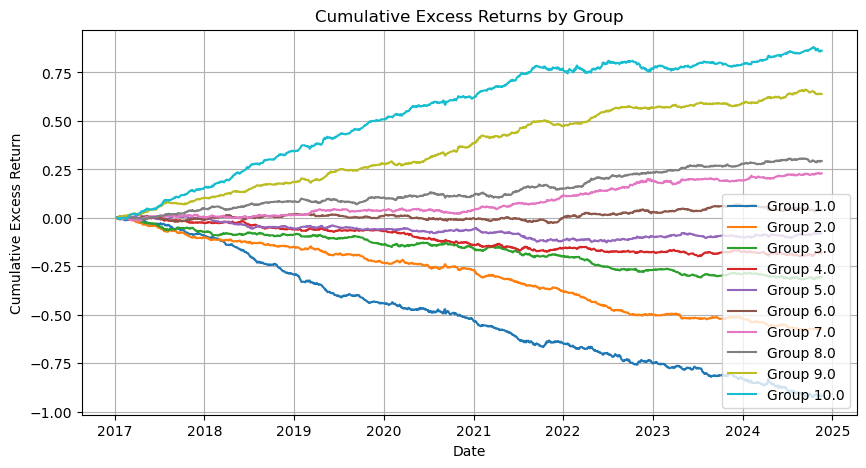

,net_excess_return,gross_excess_return,sharpe_net,sharpe_gross,turnover_rate
quantile,,,,,
0.0,-0.150710,-0.120468,-4.167586,-3.355153,0.100806
1.0,-0.133252,-0.075190,-5.264237,-3.015178,0.193540
2.0,-0.106745,-0.039905,-4.401164,-1.681491,0.222800
3.0,-0.092667,-0.023904,-3.852881,-1.010742,0.229209
4.0,-0.079699,-0.010493,-3.380203,-0.450958,0.230687
5.0,-0.063472,0.005014,-2.743636,0.220033,0.228286
6.0,-0.036655,0.030078,-1.449349,1.197429,0.222443
7.0,-0.026026,0.038491,-1.069256,1.582663,0.215058
8.0,0.027588,0.083845,1.067461,3.236418,0.187523


In [39]:
calculate_and_plot_ic(df_eps, factor='neu_DST2_zscore_process', ret='ret_daily', ic_type='both')

# 算benchmark
df1 = calculate_benchmark_return(df_eps, 'neu_DST2_zscore_process', 'ret_overnight', 'ret_day', 'ret_daily')

df1['neu_DST2_zscore_process'] = df1['neu_DST2_zscore_process'].astype('float')

# 分组
df1 = custom_quantile_grouping(df1, 'date', 'neu_DST2_zscore_process')

pnl_result = get_pnl(df1)

plot_cumulative_returns(pnl_result.pivot(index='date', columns='quantile', values='cum_gross_excess'))

calculate_annual_metrics(pnl_result)